In [1]:
import pandas as pd
import requests as rq

url = 'https://servicodados.ibge.gov.br/api/v1/localidades/estados/pa/municipios'
   
res = rq.request("GET", url)

#Creates a data frame with the Municipalities column.
if res.status_code == 200:
    df_munic = pd.DataFrame({'id': [], 'localidade': []})
    
    for id, munic in enumerate(res.json()):
        if munic['nome'] != 'Mojuí dos Campos':
            df_munic.loc[id] = [str(munic['id'])[:6], munic['nome']]


    90201: Delegacia especializada no Atendimento à Mulher
    90358: Ações de Enfrentamento à Violência contra a Mulher
    90272: Ações Socioeducativas - Violência doméstica e de gênero
    
    90640: Políticas ou programas na área de direitos humanos - Proteção de mulheres vítimas de violência doméstica 
    90626: Direitos ou política para mulheres
    
    90335: Executa programas e ações para grupos específicos - Mulheres
    90397: Constituição de centros de referência e atendimento em direitos humanos

In [2]:
indicators = ['90201','90335','90358','90626','90640', '90272', '90397']

url = "https://servicodados.ibge.gov.br/api/v1/pesquisas/1/periodos/2019/indicadores/"

# Adding indicators to the end of the url
for i, ind in enumerate(indicators):
    if i != (len(indicators)-1):
        url += ind + '|'
    else:
        url += ind + '/'
        
# Function to Formatting final url
def urlResultadosPorMunicipos(url, df):
    url += 'resultados/'    

    for i, row in df.iterrows():
        if i != (len(df)):
            url += row.id + '|'
        else:
            url += row.id + '/'
    
    return url


url = urlResultadosPorMunicipos(url, df_munic)

# return json results
res = rq.request("GET", url)


In [3]:
ExcelentEquipaments = [90201, 90358, 90272]
GoodEquipaments = [90626, 90640]
okEquipaments = [90335, 90397]

if res.status_code == 200:
    
    #Scrolls through the json and inserts the data into the main dataframe for each selected indicator.
    for indicador in res.json():
        df_temp = pd.DataFrame(indicador['res'])
        df_temp = df_temp[['localidade', 'res']]
        df_temp.rename(columns = {'localidade':'id', 'res': indicador['id']}, inplace = True)
        
        #It replaces the words "Yes" and "No" with binary information 1 and 0.
        if indicador['id'] in ExcelentEquipaments:
            df_temp[indicador['id']] = df_temp[indicador['id']].map(lambda x: 1.5 if x['2019']  == 'Sim' else 0)

        elif indicador['id'] in GoodEquipaments:
            df_temp[indicador['id']] = df_temp[indicador['id']].map(lambda x: 0.5 if x['2019']  == 'Sim' else 0)

        else:
            df_temp[indicador['id']] = df_temp[indicador['id']].map(lambda x: 0.2 if x['2019']  == 'Sim' else 0)

        df_munic = pd.merge(df_munic, df_temp, on="id")

  90201: Delegacia especializada no Atendimento à Mulher
  90358: Enfrentamento à Violência contra a Mulher
  90272: Ações Socioeducativas - Violência doméstica e de gênero

  90626: Direitos ou política para mulheres
  90640: Políticas ou programas na área de direitos humanos - Proteção de mulheres vítimas de violência doméstica 
  
    90335: Executa programas e ações para grupos específicos - Mulheres
    90397: Constituição de centros de referência e atendimento em direitos humanos

In [4]:
df_munic['Rede_de_Protecao_assistencia'] = df_munic[90201] + df_munic[90272] + df_munic[90335] + df_munic[90358] + df_munic[90397] + df_munic[90626] + df_munic[90640]

df_munic = df_munic[['id', 'localidade', 'Rede_de_Protecao_assistencia']]

In [5]:
url = "https://servicodados.ibge.gov.br/api/v1/pesquisas/37/periodos/2010/indicadores/30255/"

url = urlResultadosPorMunicipos(url, df_munic)
        
res = rq.request("GET", url)

# correction of missing values
x = res.json()
x[0]['res'][73]['res']['2010'] = '0'
x

df_temp = pd.json_normalize(x[0]['res'])
df_temp.rename(columns={'localidade': 'id', 'res.2010': 'IDH'}, inplace=True)
df_temp = df_temp[['id', 'IDH']]
df_munic = pd.merge(df_munic, df_temp, on='id')

In [6]:
url = "https://servicodados.ibge.gov.br/api/v1/pesquisas/38/periodos/2019/indicadores/47001/"

url = urlResultadosPorMunicipos(url, df_munic)   
res = rq.request("GET", url)
df_temp = pd.json_normalize(res.json()[0]['res'])
df_temp.rename(columns={'localidade': 'id', 'res.2019': 'PIB'}, inplace=True)
df_temp = df_temp[['id', 'PIB']]
df_munic = pd.merge(df_munic, df_temp, on='id')

In [7]:
url = "https://servicodados.ibge.gov.br/api/v1/pesquisas/36/periodos/2003/indicadores/30252/"

url = urlResultadosPorMunicipos(url, df_munic)
        
res = rq.request("GET", url)
# correction of missing values
x = res.json()
x[0]['res'].append({'localidade': '150475', 'res': {'2003': '0.00'}, 'notas': {'2003': None}})

df_temp =  pd.json_normalize(x[0]['res'])

df_temp.rename(columns={'localidade': 'id', 'res.2003': 'GINI'}, inplace=True)
df_temp = df_temp[['id', 'GINI']]
df_munic = pd.merge(df_munic, df_temp, on='id', how='left')
df_munic['GINI'] = pd.to_numeric(df_munic['GINI'])
df_munic['GINI'] = df_munic.iloc[:, 5:6].apply(lambda x: -x.abs(), axis=1)


In [8]:
df_munic

,id,localidade,Rede_de_Protecao_assistencia,IDH,PIB,GINI
0,150010,Abaetetuba,2.7,0.628,9458.72,-0.40
1,150013,Abel Figueiredo,0.5,0.622,11420.76,-0.37
2,150020,Acará,1.2,0.506,13582.97,-0.36
3,150030,Afuá,1.2,0.489,9405.70,-0.39
4,150034,Água Azul do Norte,0.5,0.564,15819.85,-0.37
...,...,...,...,...,...,...
138,150815,Uruará,0.2,0.589,13401.03,-0.38
139,150820,Vigia,0.0,0.617,7216.02,-0.36
140,150830,Viseu,0.2,0.515,7952.36,-0.37
141,150835,Vitória do Xingu,2.7,0.596,270414.24,-0.38


In [9]:
df_munic['Rede_de_Protecao_assistencia'] = pd.to_numeric(df_munic['Rede_de_Protecao_assistencia'])
df_munic['IDH'] = pd.to_numeric(df_munic['IDH'])
df_munic['PIB'] = pd.to_numeric(df_munic['PIB'])
df_munic['GINI'] = pd.to_numeric(df_munic['GINI'])

In [10]:
df_munic.describe()

,Rede_de_Protecao_assistencia,IDH,PIB,GINI
count,143.000000,143.000000,143.000000,143.000000
mean,0.806294,0.577427,18141.550420,-0.375594
std,0.996559,0.074148,33510.192568,0.025109
min,0.000000,0.000000,5391.060000,-0.490000
25%,0.200000,0.546500,8251.575000,-0.390000
50%,0.500000,0.582000,10806.820000,-0.380000
75%,0.700000,0.614000,16126.190000,-0.360000
max,5.700000,0.746000,288658.150000,-0.330000


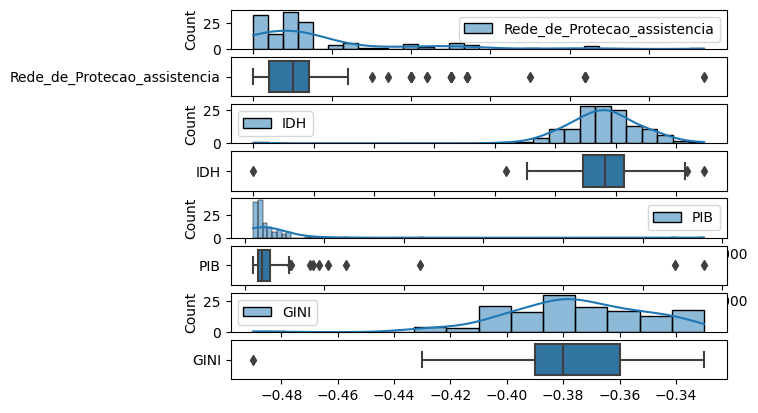

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

p1 = df_munic.iloc[:,2:3]
p2 = df_munic.iloc[:,3:4]
p3 = df_munic.iloc[:,4:5]
p4 = df_munic.iloc[:,5:6]

fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8) = plt.subplots(8)
sns.histplot(p1, kde=True, ax=ax1)
sns.boxplot(p1, orient="h", ax=ax2)
sns.histplot(p2, kde=True, ax=ax3)
sns.boxplot(p2, orient="h", ax=ax4)
sns.histplot(p3, kde=True, ax=ax5)
sns.boxplot(p3, orient="h", ax=ax6)
sns.histplot(p4, kde=True, ax=ax7)
sns.boxplot(p4, orient="h", ax=ax8)
#plt.xlim(-1, 1)
plt.show()


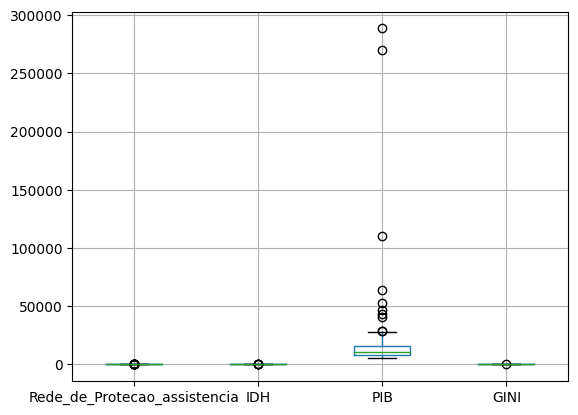

In [12]:
_, bp = pd.DataFrame.boxplot(df_munic.iloc[:,2:6], return_type='both')

plt.show()

In [13]:
## Remover Mojuí dos campus

df_munic.query('localidade == "Mojuí dos Campos"')


,id,localidade,Rede_de_Protecao_assistencia,IDH,PIB,GINI


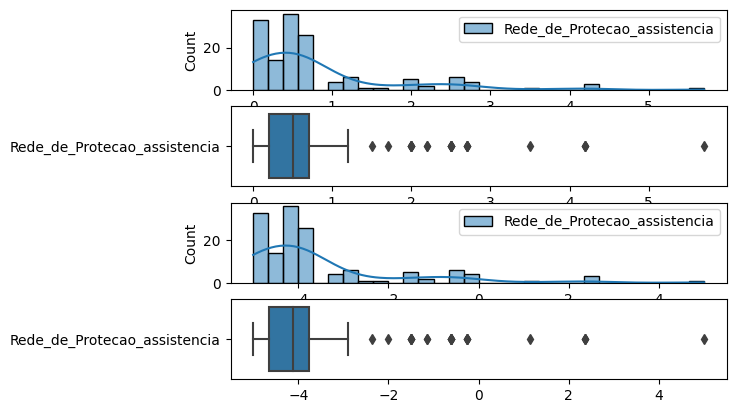

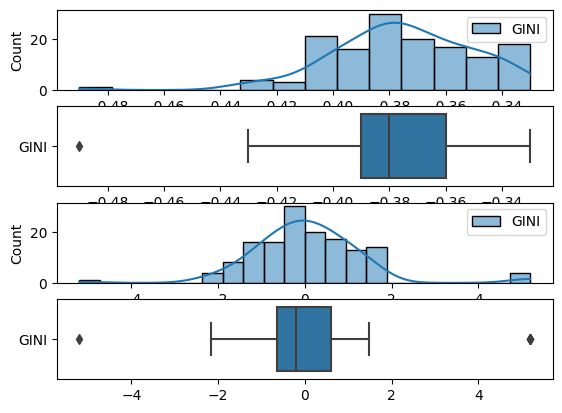

In [14]:
from sklearn import preprocessing
import pandas as pd
import numpy as np

rng = np.random.RandomState(10)

scaler1 = preprocessing.MinMaxScaler(feature_range=(-5,5))
scaler2 = preprocessing.QuantileTransformer(n_quantiles=100, output_distribution="normal", random_state=12, copy=True)
scaler3 = preprocessing.PowerTransformer(method="yeo-johnson")
# transform training data & save lambda value


d1 = scaler1.fit_transform(df_munic.iloc[:,2:3])
d2 = scaler2.fit_transform(df_munic.iloc[:,3:4])
d3 = scaler2.fit_transform(df_munic.iloc[:,4:5])
d4 = scaler2.fit_transform(df_munic.iloc[:,5:6])


ds = [d1, d2, d3, d4]

scaled_df = pd.DataFrame()
cont = 2
for i in ds:

    s_df = pd.DataFrame(i, columns=df_munic.iloc[:,cont:cont+1].columns)
    scaled_df = pd.concat([scaled_df, s_df], axis=1)
    cont += 1

scaled_df = pd.concat([df_munic.iloc[:,:2], scaled_df], axis=1)
#scaled_df

import matplotlib.pyplot as plt
import seaborn as sns

splot = scaled_df.iloc[:,2:3]
dplot = df_munic.iloc[:,2:3]

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4)
sns.histplot(dplot, kde=True, ax=ax1)
sns.boxplot(dplot, orient="h", ax=ax2)
sns.histplot(splot, kde=True, ax=ax3)
sns.boxplot(splot, orient="h", ax=ax4)
#plt.xlim(-1, 1)
plt.show()

splot = scaled_df.iloc[:,5:6]
dplot = df_munic.iloc[:,5:6]

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4)
sns.histplot(dplot, kde=True, ax=ax1)
sns.boxplot(dplot, orient="h", ax=ax2)
sns.histplot(splot, kde=True, ax=ax3)
sns.boxplot(splot, orient="h", ax=ax4)
#plt.xlim(-1, 1)
plt.show()



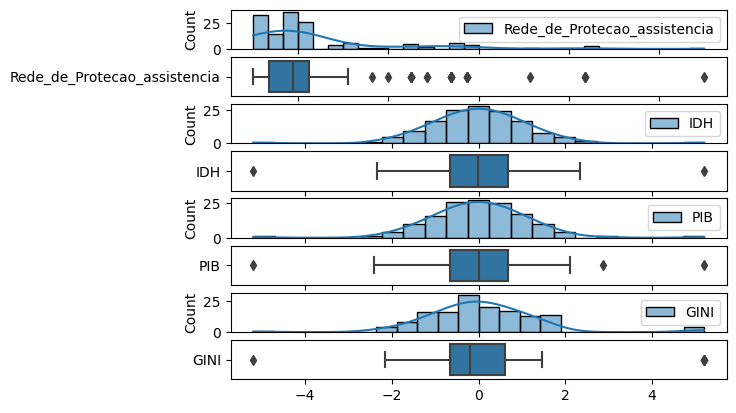

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

p1 = scaled_df.iloc[:,2:3]
p2 = scaled_df.iloc[:,3:4]
p3 = scaled_df.iloc[:,4:5]
p4 = scaled_df.iloc[:,5:6]

fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8) = plt.subplots(8)
sns.histplot(p1, kde=True, ax=ax1)
sns.boxplot(p1, orient="h", ax=ax2)
sns.histplot(p2, kde=True, ax=ax3)
sns.boxplot(p2, orient="h", ax=ax4)
sns.histplot(p3, kde=True, ax=ax5)
sns.boxplot(p3, orient="h", ax=ax6)
sns.histplot(p4, kde=True, ax=ax7)
sns.boxplot(p4, orient="h", ax=ax8)
#plt.xlim(-1, 1)
plt.show()

In [16]:
scaled_df.describe()

,Rede_de_Protecao_assistencia,IDH,PIB,GINI
count,143.000000,143.000000,143.000000,143.000000
mean,-3.585450,0.002627,0.002792,0.064918
std,1.748348,1.143351,1.149648,1.323802
min,-5.000000,-5.199338,-5.199338,-5.199338
25%,-4.649123,-0.666898,-0.669970,-0.650837
50%,-4.122807,-0.012660,0.000750,-0.203961
75%,-3.771930,0.681502,0.675503,0.604585
max,5.000000,5.199338,5.199338,5.199338


In [17]:
scaled_df

,id,localidade,Rede_de_Protecao_assistencia,IDH,PIB,GINI
0,150010,Abaetetuba,-0.263158,0.872794,-0.283961,-1.051717
1,150013,Abel Figueiredo,-4.122807,0.764710,0.199599,0.242903
2,150020,Acará,-2.894737,-1.288789,0.393296,0.604585
3,150030,Afuá,-2.894737,-1.639976,-0.298733,-0.650837
4,150034,Água Azul do Norte,-4.122807,-0.269066,0.629123,0.242903
...,...,...,...,...,...,...
138,150815,Uruará,-4.649123,0.165327,0.373610,-0.203961
139,150820,Vigia,-5.000000,0.730403,-1.350526,0.604585
140,150830,Viseu,-4.649123,-1.120205,-0.779782,0.242903
141,150835,Vitória do Xingu,-0.263158,0.379623,2.862648,-0.203961


In [18]:
scaled_df.isna().value_counts()

id     localidade  Rede_de_Protecao_assistencia  IDH    PIB    GINI 
False  False       False                         False  False  False    143
dtype: int64

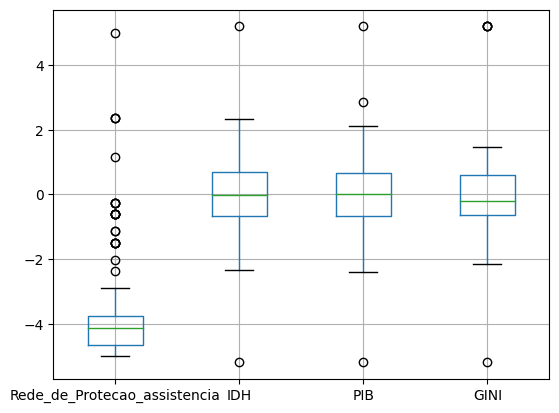

array([[-4.64912281e+00, -6.66897710e-01, -6.69969511e-01,
        -6.50837306e-01],
       [-4.12280702e+00, -1.26600769e-02,  7.49818370e-04,
        -2.03961176e-01],
       [-3.77192982e+00,  6.81501718e-01,  6.75502903e-01,
         6.04585347e-01],
       [-2.89473684e+00,  2.33961382e+00,  2.11831246e+00,
         1.47054524e+00]])

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def create_boxplot(dataset):

    Q3 = np.quantile(dataset, 0.75)
    Q1 = np.quantile(dataset, 0.25)
    MEDIAN = np.quantile(dataset, 0.50)
    IQR = Q3 - Q1

    lower_range = Q1 - 0.15 * IQR
    upper_range = Q3 + 0.15 * IQR

    while lower_range < 0:
        dst = dataset[dataset[dataset.columns[0]] > Q1]
        
        Q3 = np.quantile(dst, 0.75)
        Q1 = np.quantile(dst, 0.25)
        MEDIAN = np.quantile(dst, 0.50)
        IQR = Q3 - Q1
    
        lower_range = Q1 - 0.15 * IQR
        upper_range = Q3 + 0.15 * IQR

        dataset = dst
        
    print(f"Q3 = {Q3}")
    print(f"Q1 = {Q1}")
    print(f"IQR = {IQR}")
    print(f"Median = {MEDIAN}")
    print(f"Lower_Range = {lower_range}")
    print(f"Upper_Range = {upper_range}")
    
    
def print_limits(dataset) -> np.array:

    res = np.zeros((4, 4))

    #boxplot create
    _, bp = pd.DataFrame.boxplot(dataset, return_type='both')
    caps = [cap.get_ydata() for cap in bp["caps"]] # limites inferior e superior
    outliers = [flier.get_ydata() for flier in bp["fliers"]]  # Desconsiderar
    boxes = [box.get_ydata() for box in bp["boxes"]] # Q1 e Q3
    medians = [median.get_ydata() for median in bp["medians"]] # Mediana
    whiskers = [whiskers.get_ydata() for whiskers in bp["whiskers"]] # Q1 Q3 LimSup LimInf
    plt.show()

    cont = 0
    for c in range(0, len(whiskers), 2):
        lower_range = whiskers[c][1]

        Q1 = whiskers[c][0]
        M = medians[cont][0]
        Q3 = whiskers[c+1][0]

        upper_range = whiskers[c+1][1]

        

        # res[0][cont] = lower_range
        # res[1][cont] = Q1
        # res[2][cont] = M
        # res[3][cont] = Q3
        # res[4][cont] = upper_range

        res[0][cont] = Q1
        res[1][cont] = M
        res[2][cont] = Q3
        res[3][cont] = upper_range


        cont += 1
    
    
    return res
         

print_limits(scaled_df.iloc[:,2:6])

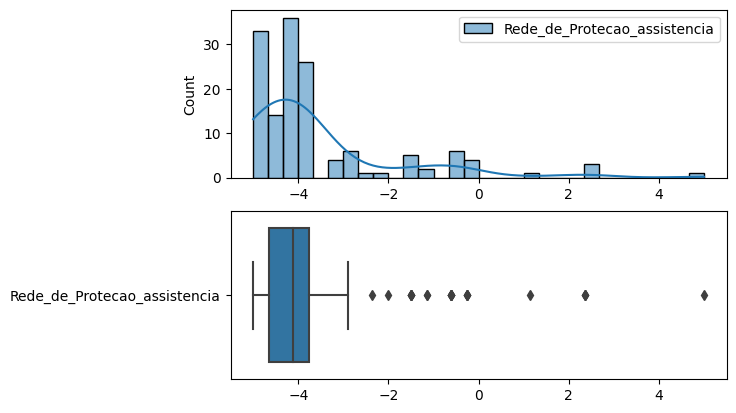

In [20]:

dplot = scaled_df.iloc[:,2:3]

fig, (ax1, ax2) = plt.subplots(2)
sns.histplot(dplot, kde=True, ax=ax1)
sns.boxplot(dplot, orient="h", ax=ax2)
#plt.xlim(-1, 1)
plt.show()

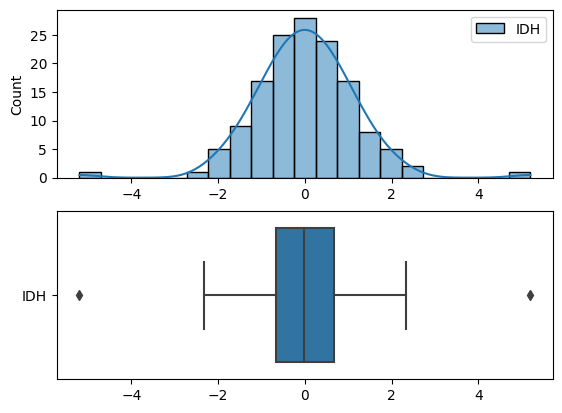

In [21]:
dplot = scaled_df.iloc[:,3:4]

fig, (ax1, ax2) = plt.subplots(2)
sns.histplot(dplot, kde=True, ax=ax1)
sns.boxplot(dplot, orient="h", ax=ax2)
plt.show()

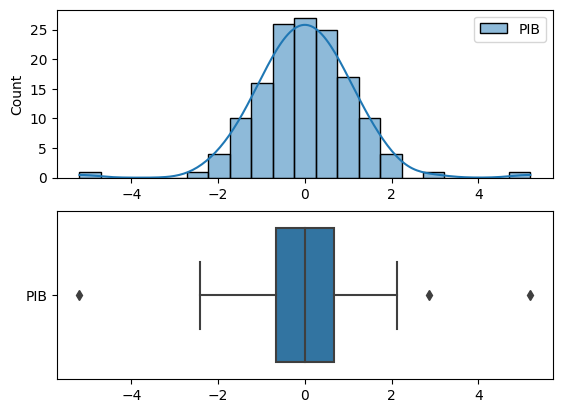

In [22]:
dplot = scaled_df.iloc[:,4:5]

fig, (ax1, ax2) = plt.subplots(2)
sns.histplot(dplot, kde=True, ax=ax1)
sns.boxplot(dplot, orient="h", ax=ax2)
plt.show()

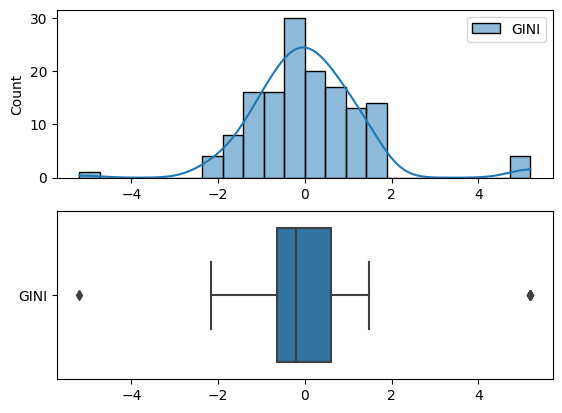

In [23]:
dplot = scaled_df.iloc[:,5:6]

fig, (ax1, ax2) = plt.subplots(2)
sns.histplot(dplot, kde=True, ax=ax1)
sns.boxplot(dplot, orient="h", ax=ax2)
plt.show()

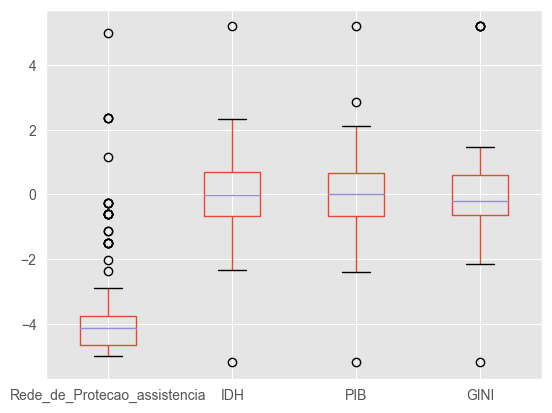

array([[-4.64912281e+00, -6.66897710e-01, -6.69969511e-01,
        -6.50837306e-01],
       [-4.12280702e+00, -1.26600769e-02,  7.49818370e-04,
        -2.03961176e-01],
       [-3.77192982e+00,  6.81501718e-01,  6.75502903e-01,
         6.04585347e-01],
       [-2.89473684e+00,  2.33961382e+00,  2.11831246e+00,
         1.47054524e+00]])

In [55]:
     #IP       #IDH      #PIB      #GINI
Q = [0.1,      0.1,       0.1,      0.1]
P = [0.2,      0.2,       0.2,      0.2]
V = [4.0,      4.0,       4.0,      4.0]
W = [0.5,      0.5,       0.5,      0.5]

B = print_limits(scaled_df.iloc[:,2:6]).tolist()

np.array(B)

In [56]:

###############################################################################

# Required Libraries
import copy
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD

###############################################################################

# Function: Plot Projected Points 
def plot_points(data, classification):
    plt.style.use('ggplot')
    colors = {'A':'#54FF00', 'B':'#BDFF00', 'C':'#FFEB00', 'D':'#FF9500', 'E':'#FF0000', 'F':'#ff796c', 'G':'#04d8b2', 'H':'#ffb07c', 'I':'#aaa662', 'J':'#0485d1', 'K':'#fffe7a', 'L':'#b0dd16', 'M':'#85679', 'N':'#12e193', 'O':'#82cafc', 'P':'#ac9362', 'Q':'#f8481c', 'R':'#c292a1', 'S':'#c0fa8b', 'T':'#ca7b80', 'U':'#f4d054', 'V':'#fbdd7e', 'W':'#ffff7e', 'X':'#cd7584', 'Y':'#f9bc08', 'Z':'#c7c10c'}
    classification_ = copy.deepcopy(classification)
    color_leg = {}
    if (data.shape[1] == 2):
        data_proj = np.copy(data)
    else:
        tSVD      = TruncatedSVD(n_components = 2, n_iter = 100, random_state = 42)
        tSVD_proj = tSVD.fit_transform(data)
        data_proj = np.copy(tSVD_proj)
        #variance  = sum(np.var(tSVD_proj, axis = 0) / np.var(tSVD_proj, axis = 0).sum())
    class_list  = list(set(classification_))
    for i in range(0, len(classification_)):
        classification_[i] = str(classification_[i])
    for i in range(0, len(classification_)):
        for j in range(0, len(class_list)):
            classification_[i] = classification_[i].replace(str(class_list[j]), str(chr(ord('A') + class_list[j])))
    class_list = list(set(classification_))
    class_list.sort() 
    for i in range(0, len(class_list)):
        color_leg[class_list[i]] = colors[class_list[i]]
    patchList = []
    for key in color_leg:
        data_key = mpatches.Patch(color = color_leg[key], label = key)
        patchList.append(data_key)
    for i in range(0, data_proj.shape[0]):
        plt.text(data_proj[i, 0], data_proj[i, 1], 'x' + str(i+1), size = 10, ha = 'center', va = 'center', bbox = dict(boxstyle = 'round', ec = (0.0, 0.0, 0.0), fc = colors[classification_[i]],))
    plt.gca().legend(handles = patchList, loc = 'center left', bbox_to_anchor = (1.05, 0.5))
    axes = plt.gca()
    xmin = np.amin(data_proj[:,0])
    xmax = np.amax(data_proj[:,0])
    #axes.set_xlim([xmin*0.7, xmax*1])
    axes.set_xlim([xmin, xmax*1])
    ymin = np.amin(data_proj[:,1])
    ymax = np.amax(data_proj[:,1])
    if (ymin < ymax):
        axes.set_ylim([ymin, ymax])
    else:
        axes.set_ylim([ymin*0.7, ymax*1])
    plt.show()

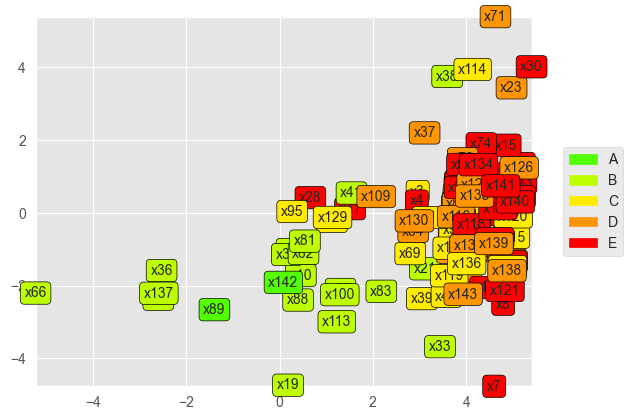

In [58]:
from pyDecision.algorithm import electre_tri_b

classification = electre_tri_b(np.array(scaled_df.iloc[:, 2:6]), W , Q , P , V , B, cut_level = 0.5, verbose = False, rule = 'pc', graph = False)

plot_points(np.array(scaled_df.iloc[:, 2:6]), classification)

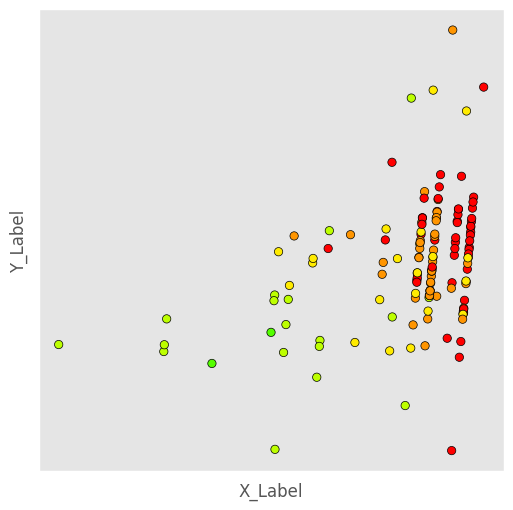

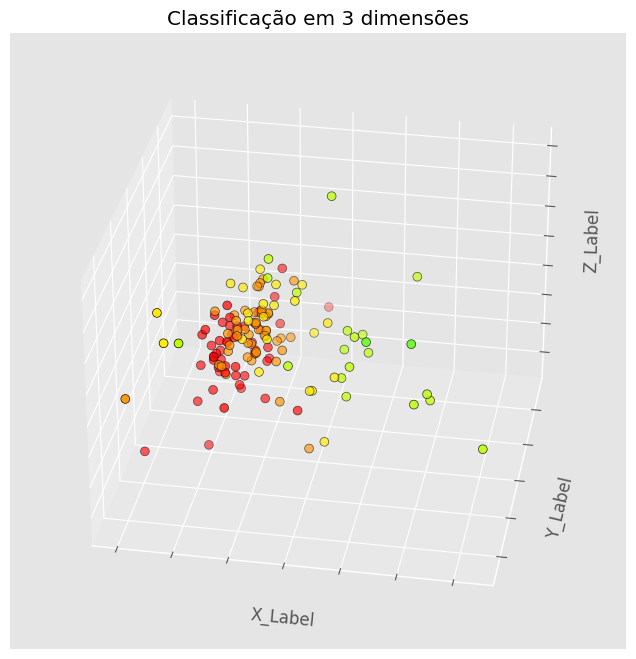

In [27]:
# Code source: Gaël Varoquaux
# Modified for documentation by Jaques Grobler
# License: BSD 3 clause

import matplotlib.pyplot as plt

# unused but required import for doing 3d projections with matplotlib < 3.2
import mpl_toolkits.mplot3d  # noqa: F401

from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
import matplotlib as mpl

from matplotlib.colors import ListedColormap


# import some data to play with
#iris = datasets.load_iris()
iris = scaled_df.iloc[:, 2:6]

tSVD      = TruncatedSVD(n_components = 2, n_iter = 100, random_state = 42)
tSVD_proj = tSVD.fit_transform(iris)
data_proj = np.copy(tSVD_proj)


#X = iris.data[:, :2]
X = data_proj # we only take the first two features.

#y = iris.target
y = classification



x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

plt.figure(2, figsize=(6, 6))
plt.clf()

cmap = ListedColormap(['#54FF00', '#BDFF00', '#FFEB00', '#FF9500', '#FF0000'])
#bounds = [-4, -1, -0.5, 0,  0.5, 1,]
#norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

# Plot the training points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap, edgecolor="k")
#plt.scatter(X[:, 0], X[:, 1], c=y, edgecolor="k")
plt.xlabel("X_Label")
plt.ylabel("Y_Label")

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())

# To getter a better understanding of interaction of the dimensions
# plot the first three PCA dimensions
fig = plt.figure(1, figsize=(8, 8))
#elev=-150, 
ax = fig.add_subplot(111, projection="3d", azim=-80)


X_reduced = PCA(n_components=3).fit_transform(iris)
ax.scatter(
    X_reduced[:, 0],
    X_reduced[:, 1],
    X_reduced[:, 2],
    c=y,
    cmap=cmap,
    edgecolor="k",
    s=40,
    marker='o'
)

ax.set_title("Classificação em 3 dimensões")
ax.set_xlabel("X_Label")
ax.xaxis.set_ticklabels([])
ax.set_ylabel("Y_Label")
ax.yaxis.set_ticklabels([])
ax.set_zlabel("Z_Label")
ax.zaxis.set_ticklabels([])

plt.show()


In [28]:
scaled_df['CLASS'] = classification

In [29]:
#scaled_df.query('CLASS == 3').shape
scaled_df['CLASS'].value_counts()


4    53
3    47
2    22
1    19
0     2
Name: CLASS, dtype: int64

In [30]:
scaled_df.query('CLASS == 0')

,id,localidade,Rede_de_Protecao_assistencia,IDH,PIB,GINI,CLASS
88,150553,Parauapebas,1.140351,2.295184,2.118312,-0.650837,0
141,150835,Vitória do Xingu,-0.263158,0.379623,2.862648,-0.203961,0


In [31]:
scaled_df = scaled_df.rename(index=lambda s: 'x' + str(s + 1))

In [32]:
scaled_df.query('CLASS == 4')

,id,localidade,Rede_de_Protecao_assistencia,IDH,PIB,GINI,CLASS
x4,150030,Afuá,-2.894737,-1.639976,-0.298733,-0.650837,4
x6,150040,Alenquer,-5.000000,-0.269066,-0.104590,-0.650837,4
x7,150050,Almeirim,-5.000000,1.076062,0.641413,-5.199338,4
x8,150060,Altamira,-5.000000,1.399657,1.184635,-1.051717,4
x9,150070,Anajás,-4.122807,-1.740244,-1.249282,0.604585,4
x11,150085,Anapu,-5.000000,-0.574460,0.534184,-1.051717,4
x12,150090,Augusto Corrêa,-4.122807,-1.057326,-1.535007,-1.051717,4
x13,150095,Aurora do Pará,-5.000000,-1.074880,-1.574313,0.604585,4
x14,150100,Aveiro,-4.122807,-0.808844,-1.045288,0.604585,4
x15,150110,Bagre,-4.649123,-1.987545,-2.010566,0.242903,4


In [33]:
import geopandas as gpd

gdf_munic = gpd.read_file('json/munics.geojson')

for value in gdf_munic['id']:
    gdf_munic['id'].replace(to_replace=value, value=value[:6], regex=True,inplace=True)


df_teste = pd.merge(scaled_df, gdf_munic, on='id', how='left')

df_teste = df_teste[['id', 'localidade', 'geometry']]

df_teste['classe'] = classification

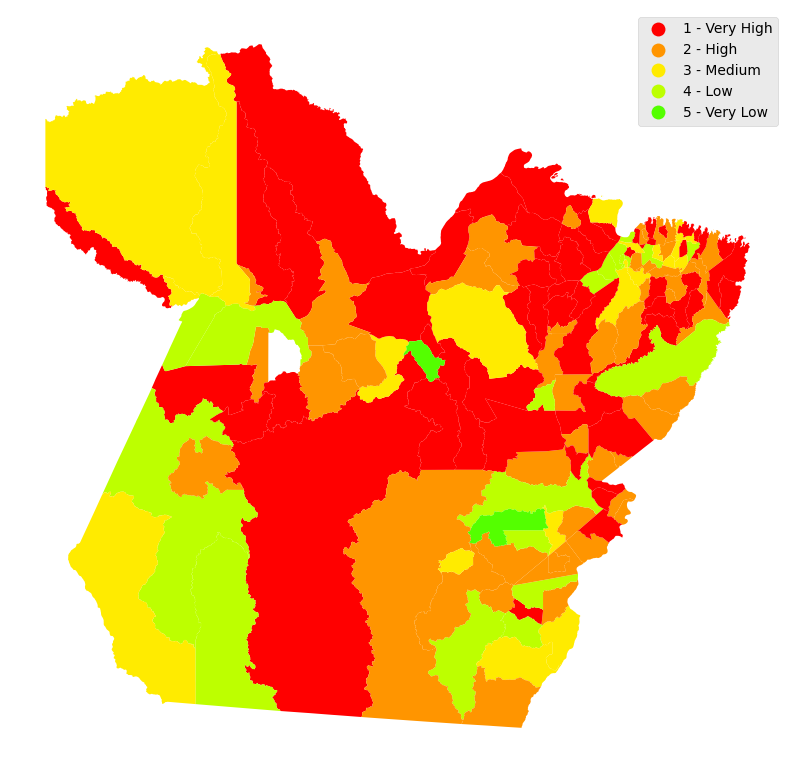

In [34]:
clusdict={5: '1 - Extremely High', 4: '1 - Very High', 3: '2 - High', 2: '3 - Medium', 1: '4 - Low', 0: '5 - Very Low' }
df_teste['legenda'] = df_teste['classe'].map(clusdict)
df_teste['classe'] = classification

gpd_teste = gpd.GeoDataFrame(df_teste)
cmap_r = cmap.reversed()
ax = gpd_teste.plot(column='legenda', categorical=True, legend=True, legend_kwds={'loc': 'upper right'}, figsize=(10,10), cmap=cmap_r)

def replace_legend_items(legend, mapping):
    for txt in legend.texts:
        for k,v in mapping.items():
            if txt.get_text() == str(k):
                txt.set_text(v)

replace_legend_items(ax.get_legend(), clusdict)

ax.set_axis_off()

In [35]:
denuncias = pd.read_json('json/casos_violencia_por_municipio.json')

denuncias = denuncias.rename(index=lambda s: 'x' + str(s + 1))

scaled_df['denuncias'] = denuncias['casos']

In [36]:
scaled_df

,id,localidade,Rede_de_Protecao_assistencia,IDH,PIB,GINI,CLASS,denuncias
x1,150010,Abaetetuba,-0.263158,0.872794,-0.283961,-1.051717,1,77
x2,150013,Abel Figueiredo,-4.122807,0.764710,0.199599,0.242903,3,0
x3,150020,Acará,-2.894737,-1.288789,0.393296,0.604585,2,11
x4,150030,Afuá,-2.894737,-1.639976,-0.298733,-0.650837,4,1
x5,150034,Água Azul do Norte,-4.122807,-0.269066,0.629123,0.242903,3,4
...,...,...,...,...,...,...,...,...
x139,150815,Uruará,-4.649123,0.165327,0.373610,-0.203961,3,2
x140,150820,Vigia,-5.000000,0.730403,-1.350526,0.604585,4,10
x141,150830,Viseu,-4.649123,-1.120205,-0.779782,0.242903,4,4
x142,150835,Vitória do Xingu,-0.263158,0.379623,2.862648,-0.203961,0,6


In [37]:
df_munic

,id,localidade,Rede_de_Protecao_assistencia,IDH,PIB,GINI
0,150010,Abaetetuba,2.7,0.628,9458.72,-0.40
1,150013,Abel Figueiredo,0.5,0.622,11420.76,-0.37
2,150020,Acará,1.2,0.506,13582.97,-0.36
3,150030,Afuá,1.2,0.489,9405.70,-0.39
4,150034,Água Azul do Norte,0.5,0.564,15819.85,-0.37
...,...,...,...,...,...,...
138,150815,Uruará,0.2,0.589,13401.03,-0.38
139,150820,Vigia,0.0,0.617,7216.02,-0.36
140,150830,Viseu,0.2,0.515,7952.36,-0.37
141,150835,Vitória do Xingu,2.7,0.596,270414.24,-0.38


In [38]:
pd.concat([df_munic.iloc[:,2:3].rename(index=lambda s: 'x' + str(s + 1)), scaled_df.iloc[:,7:8]], axis=1)



,Rede_de_Protecao_assistencia,denuncias
x1,2.7,77
x2,0.5,0
x3,1.2,11
x4,1.2,1
x5,0.5,4
...,...,...
x139,0.2,2
x140,0.0,10
x141,0.2,4
x142,2.7,6


[Text(0.5, 0, 'Support and Protection Index (IAP)'),
 Text(0, 0.5, 'Denunciations')]

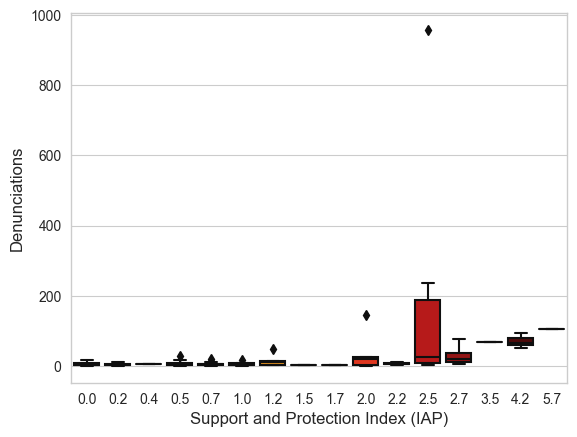

In [39]:
data = pd.concat([df_munic.iloc[:,2:3].rename(index=lambda s: 'x' + str(s + 1)), scaled_df.iloc[:,7:8]], axis=1)

sns.set_style("whitegrid")
 
# depict visualization
gfg = sns.boxplot(x="Rede_de_Protecao_assistencia", y="denuncias", data=data, palette='hot_r')

#gfg.set_ylim(0, 120)
gfg.set(xlabel ="Support and Protection Index (IAP)", ylabel = "Denunciations")

